# Building a Multi-Agent System with LangGraph

Welcome to the second part of our workshop! Now that we've learned the basics of LangChain and RAG, we'll explore how to build more sophisticated AI applications using **LangGraph**. We'll create a multi-agent system where different AI agents collaborate to provide comprehensive financial analysis.

## Setting Up Our Environment

Just like in our previous session, we need to set up our environment with the necessary imports and configurations. We'll use the same OpenAI models and Bloomberg news database, but we'll add some new components for our multi-agent system.

#### Global configuration

In [1]:
import os

from IPython.display import Markdown

In [2]:
if not os.environ.get("OPENAI_API_KEY"):
    raise ValueError("Please set OPENAI_API_KEY environment variable")

LLM_MODEL = "gpt-4o-mini"
LLM_TEMPERATURE = 0

EMBEDDING_MODEL = "text-embedding-3-small"
RETRIEVAL_K = 3

#### Base model

In [3]:
from langchain_openai import ChatOpenAI

In [4]:
base_model = ChatOpenAI(model=LLM_MODEL, temperature=LLM_TEMPERATURE)

#### Vector Store and Retriever

In [5]:
import pickle

from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

In [6]:
def load_documents(pickle_filepath: str) -> list[Document]:
    """Load documents from a pickle file."""
    with open(pickle_filepath, "rb") as file:
        return pickle.load(file)


def initialize_vector_store(document_chunks: list[Document]) -> Chroma:
    """Reset the Chroma collection and initialize a vector store using document chunks."""
    Chroma().reset_collection()
    embedding_model = OpenAIEmbeddings(model=EMBEDDING_MODEL)
    return Chroma.from_documents(documents=document_chunks, embedding=embedding_model)


data_dir = "../data/"
data_file = "bloomberg_financial_news_1k.pkl"

documents = load_documents(os.path.join(data_dir, data_file))

vector_store = initialize_vector_store(documents)
retriever = vector_store.as_retriever(search_kwargs={"k": RETRIEVAL_K})

#### Tools

In [7]:
from langchain_core.tools import tool

In [8]:
@tool
def retrieval(retrieval_query: str) -> list[Document]:
    """Retrieve documents based on a query."""
    return retriever.invoke(retrieval_query)


tools = [retrieval]
tools_by_name = {tool.name: tool for tool in tools}

## Understanding the Multi-Agent Workflow

Our system consists of three specialized agents working together:
1. Client Interface Agent (CIA): Analyzes client requests and plans research tasks
2. Bloomberg Research Agent (BRA): Conducts specific research using the Bloomberg news database
3. Research Synthesis Agent (RSA): Synthesizes research into final recommendations

## LangGraph Workflow and State

**LangGraph** helps us manage communication between our agents efficiently by defining a state class that will convey information from a node to the next during execution (`WorkflowState` here).

We keep our state simple by including only two attributes, but it's possible to include more:
- Messages: The ongoing conversation chain
- Analyses: Research findings from our agents

We use Python's dataclasses with special annotations (`Annotated`) to define how the state attributes should be updated throughout the workflow.

In [9]:
import operator
from dataclasses import dataclass, field
from typing import Annotated

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [10]:
@dataclass(kw_only=True)
class WorkflowState:
    """Graph state tracking for the financial analysis workflow."""

    messages: Annotated[list[BaseMessage], add_messages] = field(default_factory=list)
    analyses: Annotated[list[str], operator.add] = field(default_factory=list)

## The Agents in Detail

To build a **LangGraph** workflow, we then need to implements methods that receive state values and return state updates. These methods represent the nodes of our graph. Each node will be assigned a string name, used for creating the graph edges that define the communication flow.

We'll use the following names for our graph nodes:
- `"orchestrator"`
- `"research"`
- `"synthesizer"`

### Client Interface Agent (CIA)

The CIA serves as our system's orchestrator. It:
- Evaluates client requests
- Determines if requests are within scope
- Breaks down the request into specific tasks to be conducted by the Bloomberg Research Agents

#### Structured Outputs with Pydantic

Leveraging **Pydantic**, **LangChain** allows to constrain the output of a model using `.with_structured_output()`. Similarly to `.bind_tools()`, this provides the model with all the relevant information to structure its output in the desired way.

We define two structured outputs:
- ResearchTask: Defines specific research objectives
- OrchestratorDecision: Helps the CIA answer the client's request and plan the research tasks

This approach helps maintain consistency and reliability during our workflow execution.

In [11]:
from pydantic import BaseModel, Field

In [12]:
class ResearchTask(BaseModel):
    """Task for the financial analysis workflow."""

    topic: str = Field(description="Topic of the research task.")
    description: str = Field(
        description="Brief description of the task and its objectives."
    )


class OrchestratorDecision(BaseModel):
    """List of research tasks for the financial analysis workflow."""

    response: str = Field(description="Rationale for the decision and research tasks.")
    in_scope: bool = Field(
        description="Wether the client request is in scope for the financial analysis."
    )
    research_tasks: list[ResearchTask] | None = Field(
        description="List of research tasks to be completed."
    )

Now that the we defined our structured output, we can instanciate our Orchestrator model using `.with_structured_output()`.

In [13]:
CIA_PROMPT = """
You are a Client Interface Agent (CIA) in a financial analysis system. You have multiple Research Agents with access to Bloomberg Financial News under your supervision.

Given a client request, provide a concise, polite and professional response regarding the feasibility of the request and the approach that will be taken to address it.

If the user's request is addressable, create a short list of highly specific research topics that the Research Agents will investigate to fulfill the client's request.
"""

cia_model = base_model.with_structured_output(OrchestratorDecision)

#### Defining the Nodes and Flow

Let's now define our first graph Node. This section encompasses multiple **LangGraph** concepts at once and is worth spending some time on.

1. Defining the node:
    - To define our orchestrator node, we implement a method that receives the graph state and apply operations on it
    - In this case, the `"orchestrator"` calls the CIA model with structured output on the user request.

2. Defining the flow:
    - In December, **LangGraph** released [Command](https://blog.langchain.dev/command-a-new-tool-for-multi-agent-architectures-in-langgraph/), a novel way of defining the graph edges  directly within the nodes.
    - `Command` can return both state updates (`update`) and the next node (`go_to`).
    - In the following example, the `"orchestrator"` node updates the state messages with the CIA's response.
    - If the user request is out of scope, it terminates the workflow by going to the `END` node.
    - Otherwise, it goes to a dynamically generated number of `"research"` nodes and provide them each with a `ResearchTask`.

3. Dynamic number of nodes:
    - Using **LangGraph** `Send`, we can define the number of works dynamically.
    - In the `"orchestrator"`, one worker is created for each `ResearchTask` from the CIA.

In [14]:
from typing import Literal

from langchain_core.messages import SystemMessage
from langgraph.constants import Send
from langgraph.graph import END
from langgraph.types import Command

In [15]:
def cia(state: WorkflowState) -> Command[Literal["research", END]]:
    """Orchestrator that generates a plan for the report."""
    display(Markdown(f"**Client request received**: {state.messages[-1].content}"))

    cia_output = cia_model.invoke(
        [
            SystemMessage(CIA_PROMPT),
            *state.messages,
        ]
    )

    display(Markdown(f"**CIA Response:** {cia_output.response}"))

    return Command(
        update={"messages": cia_output.response},
        goto=[Send("research", task) for task in cia_output.research_tasks]
        if cia_output.in_scope
        else END,
    )

### Bloomberg Research Agent (BRA)

The BRA is our research specialist that:
- Receives specific research tasks from the CIA
- Queries the Bloomberg news database
- Synthesizes findings into concise research reports

This node works identically to the RAG from the first notebook.

In [16]:
from langchain_core.messages import HumanMessage, ToolMessage

In [17]:
BRA_PROMPT = """
You are a Research Agent in a financial analysis system. You are tasked with writing a concise research report on a specific topic provided by the Client Interface Agent (CIA) based on available documents.

To do so, you have access to a Bloomberg Financial News database that you can query. You should query the vector store for documents relevant to your task and write a concise summary of the information you find.

Your report should be short and informative, conveying only the most important information from the documents, to allow a Synthesis Agent to quickly generate a report for the client based on the findings of all Research Agents.
"""

bra_model = base_model.bind_tools(tools)

In [18]:
def bra(task: ResearchTask) -> Command[Literal["synthesizer"]]:
    """Research agent that can query the vector store for relevant documents."""
    display(Markdown(f"**Researching task**: {task.topic}"))

    bra_output = bra_model.invoke(
        [
            SystemMessage(BRA_PROMPT),
            HumanMessage(
                f"Research Task: {task.topic}\n\n Description: {task.description}"
            ),
        ]
    )

    if bra_output.tool_calls:
        tool_call = bra_output.tool_calls[0]
        tool = tools_by_name[tool_call["name"]]
        documents = tool.invoke(tool_call["args"])

        display(
            Markdown(
                f"**Retrieved documents**: {[doc.metadata['Headline'] for doc in documents]}"
            )
        )

        bra_output = base_model.invoke(
            [
                SystemMessage(BRA_PROMPT),
                HumanMessage(
                    f"Research Task: {task.topic}\n\n Description: {task.description}"
                ),
                bra_output,
                ToolMessage(
                    content="\n\n".join(
                        [
                            f"{doc.metadata['Headline']}\n{doc.page_content}"
                            for doc in documents
                        ]
                    ),
                    tool_call_id=tool_call["id"],
                ),
            ]
        )

    return Command(
        update={"analyses": [bra_output.content]},
        goto="synthesizer",
    )

### Research Synthesis Agent (RSA)

The RSA is our final processing layer that:
- Collects all research findings
- Cross-references different analyses
- Creates a cohesive final report for the client

It does not make use of tools nor structured outputs and should return an answer to the client based on the analyses in the state.

In [19]:
RSA_PROMPT = """
You are a Research Synthesis Agent (RSA) in a financial analysis system. You receive the reports from multiple Bloomberg Research Agents, and are tasked with synthesizing the information these reports contain into a final report for the client.

The final report should be based on the information provided by the Research Agents, covering their findings in a clear and concise manner to address the client's request.
"""

In [20]:
def rsa(state: WorkflowState) -> Command[Literal[END]]:
    """Synthesize full report from research analyses."""
    display(Markdown(f"**Synthesizing research from {len(state.analyses)} BRAs.**"))

    analyses_reports = state.analyses

    complete_analyses = "\n\n---\n\n".join(analyses_reports)

    rsa_output = base_model.invoke(
        [
            SystemMessage(RSA_PROMPT),
            *state.messages,
            HumanMessage(complete_analyses),
        ]
    )

    return Command(
        update={"messages": rsa_output},
        goto=END,
    )

## Building the Workflow Graph

Now that our nodes and communication flow are defined, we can build the graph!

In [21]:
from IPython.display import Image
from langgraph.graph import StateGraph

In [22]:
# Build workflow
graph_builder = StateGraph(WorkflowState)

# Entry point
graph_builder.set_entry_point("orchestrator")

# Add the nodes
graph_builder.add_node("orchestrator", cia)
graph_builder.add_node("research", bra)
graph_builder.add_node("synthesizer", rsa)

# The edges are defined by the commands !

# Compile the workflow
app = graph_builder.compile()

Let's visualize our Financial Analyst graph. Note that because the number of `"research"` nodes is generated dynamically, it shows up as a single node in the image.

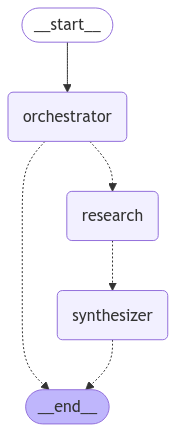

In [23]:
display(Image(app.get_graph().draw_mermaid_png()))

## Running the Workflow

Now that our workflow is built, let's test it! Once again, we can run it with `.invoke()`.

In [24]:
final_state = app.invoke(
    {
        "messages": "I want to invest in the technology sector. Can you please define an investment strategy?"
    }
)

**Client request received**: I want to invest in the technology sector. Can you please define an investment strategy?

**CIA Response:** Your request for an investment strategy in the technology sector is certainly in scope. We will focus on identifying key trends, potential high-growth companies, and risk factors associated with technology investments. Our Research Agents will gather relevant data and insights to formulate a comprehensive strategy tailored to your investment goals.

**Researching task**: Current Trends in Technology Investments

**Researching task**: Top Performing Technology Stocks

**Researching task**: Investment Strategies for Technology Sector

**Researching task**: Risk Assessment in Technology Investments

**Retrieved documents**: ['UBS’s Weber Sees Volatile Markets in 2013 on Political Risks', 'M&A Isn’t Likely to Stage ‘Major’ Recovery Yet, Shafir Says', 'BMC Software Drops After Profit Forecast Misses: Houston Mover']

**Retrieved documents**: ['Fewer U.S. Shares Available Fuels Bull Market: Chart of the Day', 'Mairs & Power’s Frels, Henneman Named Manager of the Year', 'Ceragon Jumps Most in 1 Month on Order: Israel Overnight']

**Retrieved documents**: ['Mairs & Power’s Frels, Henneman Named Manager of the Year', 'Fewer U.S. Shares Available Fuels Bull Market: Chart of the Day', 'Samsung Boosting Venture-Capital Funding to $1.1 Billion']

**Retrieved documents**: ["Obama's Budget Has Bad News for Shareholders", 'Samsung Boosting Venture-Capital Funding to $1.1 Billion', 'ARM Sees Shift to Cheaper Smartphones Boosting Chip Royalty']

**Synthesizing research from 4 BRAs.**

In [25]:
Markdown(final_state["messages"][-1].content)

### Final Investment Strategy Report: Technology Sector

#### Overview
The technology sector presents a dynamic landscape for investment, characterized by rapid innovation, evolving consumer preferences, and significant market opportunities. This report synthesizes current trends, top-performing stocks, risk assessments, and strategic investment approaches to guide your investment decisions in this sector.

#### Key Trends in Technology Investments

1. **Venture Capital Growth**: Major players like Samsung Electronics are increasing their venture capital investments, targeting early-stage startups in emerging fields such as mobile health and cloud computing. This trend indicates a robust ecosystem for innovation and potential high returns.

2. **Demand for Affordable Technology**: Companies like ARM Holdings are adapting to a shift towards lower-priced smartphones, which is expected to drive growth in royalty revenues. This trend highlights the importance of affordability in consumer technology.

3. **Focus on Disruptive Technologies**: Investment is increasingly directed towards disruptive innovations, including mobile privacy solutions and advanced human-computer interfaces. Companies that align with these trends are likely to see substantial growth.

4. **Market Dynamics**: The global smartphone market is experiencing a surge in shipments, despite declining average selling prices. This shift suggests a growing consumer base for affordable devices, prompting companies to innovate and adjust their strategies.

5. **Long-term Growth Strategies**: Firms are focusing on specialized applications, such as enterprise networking and micro-controllers, which are essential for data processing and storage. This strategic pivot is crucial for maintaining competitive advantage.

#### Top Performing Technology Stocks

1. **Apple Inc. (AAPL)**: With a robust stock buyback program, Apple is well-positioned for continued growth. Its market leadership and strategic investments make it a strong candidate for long-term investment.

2. **Ceragon Networks Ltd. (CRNT)**: While facing challenges, recent orders indicate potential for recovery. Investors should monitor demand trends closely.

3. **Caesarstone Sdot Yam Ltd. (CSTE)**: This stock has shown remarkable performance, reflecting strong market confidence. It may be a good option for growth-oriented investors.

4. **ClickSoftware Technologies Ltd. (CKSW)**: Despite recent declines, its association with significant investors suggests potential for recovery. A cautious approach is recommended.

#### Risk Assessment

Investing in the technology sector involves several risks:

1. **Market Volatility**: The sector is prone to fluctuations influenced by economic conditions and geopolitical events. Investors should be prepared for "risk-on, risk-off" periods that can affect sentiment.

2. **Regulatory Challenges**: Increasing scrutiny from regulators can impact growth opportunities, particularly in M&A activities. Companies may adopt a cautious approach in uncertain economic climates.

3. **Operational Risks**: Companies may face challenges that affect profitability, such as difficulties in securing contracts. Monitoring operational performance is essential.

4. **Interest Rate Sensitivity**: Changes in interest rates can disrupt market liquidity and affect tech companies' financial health. Investors should stay informed about macroeconomic indicators.

#### Recommended Investment Strategies

1. **Growth Investing**: Focus on companies with high growth potential, such as Apple and emerging tech startups. This strategy is suitable for investors willing to accept higher volatility for the chance of substantial returns.

2. **Value Investing**: Identify undervalued stocks with solid fundamentals. This approach may involve thorough analysis to find established firms that are temporarily overlooked by the market.

3. **Diversification**: Consider a diversified portfolio that includes both growth and value stocks to mitigate risks associated with market volatility and sector-specific challenges.

4. **Monitor Market Dynamics**: Stay informed about stock buybacks and venture capital trends, as these can significantly influence stock performance and market sentiment.

#### Conclusion

The technology sector offers a wealth of investment opportunities driven by innovation and changing consumer demands. By understanding current trends, assessing risks, and employing strategic investment approaches, you can position yourself for success in this dynamic market. Whether you choose a growth or value investing strategy, staying informed and adaptable will be key to navigating the complexities of technology investments.

## Practical Tips

- Keep agent roles clearly defined and specialized
- Use structured outputs to ensure reliable communication
- Monitor the workflow graph for potential bottlenecks
- Adjust the number of research tasks based on query complexity

## Conclusion

You've now learned how to build a sophisticated multi-agent system using **LangGraph**! This approach allows for:
- More complex and nuanced analysis
- Better division of responsibilities
- Scalable AI applications

Feel free to experiment with different agent configurations and workflow patterns to suit your specific needs.